Random Seed:  999


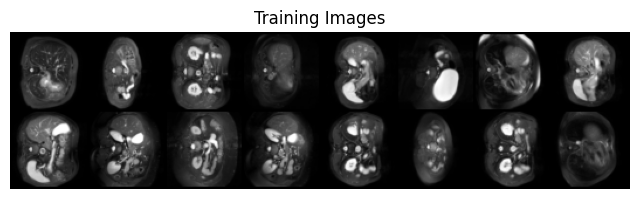

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


KeyboardInterrupt: 

In [30]:
# -*- coding: utf-8 -*-
"""
DCGAN Tutorial
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__

"""


######################################################################
# Introduction
# ------------
# 
# This tutorial will give an introduction to DCGANs through an example. We
# will train a generative adversarial network (GAN) to generate new
# celebrities after showing it pictures of many real celebrities. Most of
# the code here is from the DCGAN implementation in
# `pytorch/examples <https://github.com/pytorch/examples>`__, and this
# document will give a thorough explanation of the implementation and shed
# light on how and why this model works. But don’t worry, no prior
# knowledge of GANs is required, but it may require a first-timer to spend
# some time reasoning about what is actually happening under the hood.
# Also, for the sake of time it will help to have a GPU, or two. Lets
# start from the beginning.
# 
# Generative Adversarial Networks
# -------------------------------
# 
# What is a GAN?
# ~~~~~~~~~~~~~~
# 
# GANs are a framework for teaching a deep learning model to capture the training
# data distribution so we can generate new data from that same
# distribution. GANs were invented by Ian Goodfellow in 2014 and first
# described in the paper `Generative Adversarial
# Nets <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__.
# They are made of two distinct models, a *generator* and a
# *discriminator*. The job of the generator is to spawn ‘fake’ images that
# look like the training images. The job of the discriminator is to look
# at an image and output whether or not it is a real training image or a
# fake image from the generator. During training, the generator is
# constantly trying to outsmart the discriminator by generating better and
# better fakes, while the discriminator is working to become a better
# detective and correctly classify the real and fake images. The
# equilibrium of this game is when the generator is generating perfect
# fakes that look as if they came directly from the training data, and the
# discriminator is left to always guess at 50% confidence that the
# generator output is real or fake.
# 
# Now, lets define some notation to be used throughout tutorial starting
# with the discriminator. Let :math:`x` be data representing an image.
# :math:`D(x)` is the discriminator network which outputs the (scalar)
# probability that :math:`x` came from training data rather than the
# generator. Here, since we are dealing with images, the input to
# :math:`D(x)` is an image of CHW size 3x64x64. Intuitively, :math:`D(x)`
# should be HIGH when :math:`x` comes from training data and LOW when
# :math:`x` comes from the generator. :math:`D(x)` can also be thought of
# as a traditional binary classifier.
# 
# For the generator’s notation, let :math:`z` be a latent space vector
# sampled from a standard normal distribution. :math:`G(z)` represents the
# generator function which maps the latent vector :math:`z` to data-space.
# The goal of :math:`G` is to estimate the distribution that the training
# data comes from (:math:`p_{data}`) so it can generate fake samples from
# that estimated distribution (:math:`p_g`).
# 
# So, :math:`D(G(z))` is the probability (scalar) that the output of the
# generator :math:`G` is a real image. As described in `Goodfellow’s
# paper <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__,
# :math:`D` and :math:`G` play a minimax game in which :math:`D` tries to
# maximize the probability it correctly classifies reals and fakes
# (:math:`logD(x)`), and :math:`G` tries to minimize the probability that
# :math:`D` will predict its outputs are fake (:math:`log(1-D(G(z)))`).
# From the paper, the GAN loss function is
# 
# .. math:: \underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]
# 
# In theory, the solution to this minimax game is where
# :math:`p_g = p_{data}`, and the discriminator guesses randomly if the
# inputs are real or fake. However, the convergence theory of GANs is
# still being actively researched and in reality models do not always
# train to this point.
# 
# What is a DCGAN?
# ~~~~~~~~~~~~~~~~
# 
# A DCGAN is a direct extension of the GAN described above, except that it
# explicitly uses convolutional and convolutional-transpose layers in the
# discriminator and generator, respectively. It was first described by
# Radford et. al. in the paper `Unsupervised Representation Learning With
# Deep Convolutional Generative Adversarial
# Networks <https://arxiv.org/pdf/1511.06434.pdf>`__. The discriminator
# is made up of strided
# `convolution <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`__
# layers, `batch
# norm <https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d>`__
# layers, and
# `LeakyReLU <https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU>`__
# activations. The input is a 3x64x64 input image and the output is a
# scalar probability that the input is from the real data distribution.
# The generator is comprised of
# `convolutional-transpose <https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d>`__
# layers, batch norm layers, and
# `ReLU <https://pytorch.org/docs/stable/nn.html#relu>`__ activations. The
# input is a latent vector, :math:`z`, that is drawn from a standard
# normal distribution and the output is a 3x64x64 RGB image. The strided
# conv-transpose layers allow the latent vector to be transformed into a
# volume with the same shape as an image. In the paper, the authors also
# give some tips about how to setup the optimizers, how to calculate the
# loss functions, and how to initialize the model weights, all of which
# will be explained in the coming sections.
# 

#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


######################################################################
# Inputs
# ------
# 
# Let’s define some inputs for the run:
# 
# -  ``dataroot`` - the path to the root of the dataset folder. We will
#    talk more about the dataset in the next section.
# -  ``workers`` - the number of worker threads for loading the data with
#    the ``DataLoader``.
# -  ``batch_size`` - the batch size used in training. The DCGAN paper
#    uses a batch size of 128.
# -  ``image_size`` - the spatial size of the images used for training.
#    This implementation defaults to 64x64. If another size is desired,
#    the structures of D and G must be changed. See
#    `here <https://github.com/pytorch/examples/issues/70>`__ for more
#    details.
# -  ``nc`` - number of color channels in the input images. For color
#    images this is 3.
# -  ``nz`` - length of latent vector.
# -  ``ngf`` - relates to the depth of feature maps carried through the
#    generator.
# -  ``ndf`` - sets the depth of feature maps propagated through the
#    discriminator.
# -  ``num_epochs`` - number of training epochs to run. Training for
#    longer will probably lead to better results but will also take much
#    longer.
# -  ``lr`` - learning rate for training. As described in the DCGAN paper,
#    this number should be 0.0002.
# -  ``beta1`` - beta1 hyperparameter for Adam optimizers. As described in
#    paper, this number should be 0.5.
# -  ``ngpu`` - number of GPUs available. If this is 0, code will run in
#    CPU mode. If this number is greater than 0 it will run on that number
#    of GPUs.
#

# Root directory for dataset
dataroot = "/root/ducnt/fewshot_medical_segmentor/stylegan2/data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.01

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


######################################################################
# Data
# ----
# 
# In this tutorial we will use the `Celeb-A Faces
# dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`__ which can
# be downloaded at the linked site, or in `Google
# Drive <https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg>`__.
# The dataset will download as a file named ``img_align_celeba.zip``. Once
# downloaded, create a directory named ``celeba`` and extract the zip file
# into that directory. Then, set the ``dataroot`` input for this notebook to
# the ``celeba`` directory you just created. The resulting directory
# structure should be:
# 
# .. code-block:: sh
# 
#    /path/to/celeba
#        -> img_align_celeba  
#            -> 188242.jpg
#            -> 173822.jpg
#            -> 284702.jpg
#            -> 537394.jpg
#               ...
# 
# This is an important step because we will be using the ``ImageFolder``
# dataset class, which requires there to be subdirectories in the
# dataset root folder. Now, we can create the dataset, create the
# dataloader, set the device to run on, and finally visualize some of the
# training data.
# 

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                            #    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


######################################################################
# Implementation
# --------------
# 
# With our input parameters set and the dataset prepared, we can now get
# into the implementation. We will start with the weight initialization
# strategy, then talk about the generator, discriminator, loss functions,
# and training loop in detail.
# 
# Weight Initialization
# ~~~~~~~~~~~~~~~~~~~~~
# 
# From the DCGAN paper, the authors specify that all model weights shall
# be randomly initialized from a Normal distribution with ``mean=0``,
# ``stdev=0.02``. The ``weights_init`` function takes an initialized model as
# input and reinitializes all convolutional, convolutional-transpose, and
# batch normalization layers to meet this criteria. This function is
# applied to the models immediately after initialization.
# 

# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


######################################################################
# Generator
# ~~~~~~~~~
# 
# The generator, :math:`G`, is designed to map the latent space vector
# (:math:`z`) to data-space. Since our data are images, converting
# :math:`z` to data-space means ultimately creating a RGB image with the
# same size as the training images (i.e. 3x64x64). In practice, this is
# accomplished through a series of strided two dimensional convolutional
# transpose layers, each paired with a 2d batch norm layer and a relu
# activation. The output of the generator is fed through a tanh function
# to return it to the input data range of :math:`[-1,1]`. It is worth
# noting the existence of the batch norm functions after the
# conv-transpose layers, as this is a critical contribution of the DCGAN
# paper. These layers help with the flow of gradients during training. An
# image of the generator from the DCGAN paper is shown below.
#
# .. figure:: /_static/img/dcgan_generator.png
#    :alt: dcgan_generator
#
# Notice, how the inputs we set in the input section (``nz``, ``ngf``, and
# ``nc``) influence the generator architecture in code. ``nz`` is the length
# of the z input vector, ``ngf`` relates to the size of the feature maps
# that are propagated through the generator, and ``nc`` is the number of
# channels in the output image (set to 3 for RGB images). Below is the
# code for the generator.
# 

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


######################################################################
# Now, we can instantiate the generator and apply the ``weights_init``
# function. Check out the printed model to see how the generator object is
# structured.
# 

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)


######################################################################
# Discriminator
# ~~~~~~~~~~~~~
# 
# As mentioned, the discriminator, :math:`D`, is a binary classification
# network that takes an image as input and outputs a scalar probability
# that the input image is real (as opposed to fake). Here, :math:`D` takes
# a 3x64x64 input image, processes it through a series of Conv2d,
# BatchNorm2d, and LeakyReLU layers, and outputs the final probability
# through a Sigmoid activation function. This architecture can be extended
# with more layers if necessary for the problem, but there is significance
# to the use of the strided convolution, BatchNorm, and LeakyReLUs. The
# DCGAN paper mentions it is a good practice to use strided convolution
# rather than pooling to downsample because it lets the network learn its
# own pooling function. Also batch norm and leaky relu functions promote
# healthy gradient flow which is critical for the learning process of both
# :math:`G` and :math:`D`.
# 

#########################################################################
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


######################################################################
# Now, as with the generator, we can create the discriminator, apply the
# ``weights_init`` function, and print the model’s structure.
# 

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)


######################################################################
# Loss Functions and Optimizers
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 
# With :math:`D` and :math:`G` setup, we can specify how they learn
# through the loss functions and optimizers. We will use the Binary Cross
# Entropy loss
# (`BCELoss <https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss>`__)
# function which is defined in PyTorch as:
# 
# .. math:: \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]
# 
# Notice how this function provides the calculation of both log components
# in the objective function (i.e. :math:`log(D(x))` and
# :math:`log(1-D(G(z)))`). We can specify what part of the BCE equation to
# use with the :math:`y` input. This is accomplished in the training loop
# which is coming up soon, but it is important to understand how we can
# choose which component we wish to calculate just by changing :math:`y`
# (i.e. GT labels).
# 
# Next, we define our real label as 1 and the fake label as 0. These
# labels will be used when calculating the losses of :math:`D` and
# :math:`G`, and this is also the convention used in the original GAN
# paper. Finally, we set up two separate optimizers, one for :math:`D` and
# one for :math:`G`. As specified in the DCGAN paper, both are Adam
# optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
# of the generator’s learning progression, we will generate a fixed batch
# of latent vectors that are drawn from a Gaussian distribution
# (i.e. fixed_noise) . In the training loop, we will periodically input
# this fixed_noise into :math:`G`, and over the iterations we will see
# images form out of the noise.
# 

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


######################################################################
# Training
# ~~~~~~~~
# 
# Finally, now that we have all of the parts of the GAN framework defined,
# we can train it. Be mindful that training GANs is somewhat of an art
# form, as incorrect hyperparameter settings lead to mode collapse with
# little explanation of what went wrong. Here, we will closely follow
# Algorithm 1 from the `Goodfellow’s paper <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__, 
# while abiding by some of the best
# practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
# Namely, we will “construct different mini-batches for real and fake”
# images, and also adjust G’s objective function to maximize
# :math:`log(D(G(z)))`. Training is split up into two main parts. Part 1
# updates the Discriminator and Part 2 updates the Generator.
# 
# **Part 1 - Train the Discriminator**
# 
# Recall, the goal of training the discriminator is to maximize the
# probability of correctly classifying a given input as real or fake. In
# terms of Goodfellow, we wish to “update the discriminator by ascending
# its stochastic gradient”. Practically, we want to maximize
# :math:`log(D(x)) + log(1-D(G(z)))`. Due to the separate mini-batch
# suggestion from `ganhacks <https://github.com/soumith/ganhacks>`__,
# we will calculate this in two steps. First, we
# will construct a batch of real samples from the training set, forward
# pass through :math:`D`, calculate the loss (:math:`log(D(x))`), then
# calculate the gradients in a backward pass. Secondly, we will construct
# a batch of fake samples with the current generator, forward pass this
# batch through :math:`D`, calculate the loss (:math:`log(1-D(G(z)))`),
# and *accumulate* the gradients with a backward pass. Now, with the
# gradients accumulated from both the all-real and all-fake batches, we
# call a step of the Discriminator’s optimizer.
# 
# **Part 2 - Train the Generator**
# 
# As stated in the original paper, we want to train the Generator by
# minimizing :math:`log(1-D(G(z)))` in an effort to generate better fakes.
# As mentioned, this was shown by Goodfellow to not provide sufficient
# gradients, especially early in the learning process. As a fix, we
# instead wish to maximize :math:`log(D(G(z)))`. In the code we accomplish
# this by: classifying the Generator output from Part 1 with the
# Discriminator, computing G’s loss *using real labels as GT*, computing
# G’s gradients in a backward pass, and finally updating G’s parameters
# with an optimizer step. It may seem counter-intuitive to use the real
# labels as GT labels for the loss function, but this allows us to use the
# :math:`log(x)` part of the ``BCELoss`` (rather than the :math:`log(1-x)`
# part) which is exactly what we want.
# 
# Finally, we will do some statistic reporting and at the end of each
# epoch we will push our fixed_noise batch through the generator to
# visually track the progress of G’s training. The training statistics
# reported are:
# 
# -  **Loss_D** - discriminator loss calculated as the sum of losses for
#    the all real and all fake batches (:math:`log(D(x)) + log(1 - D(G(z)))`).
# -  **Loss_G** - generator loss calculated as :math:`log(D(G(z)))`
# -  **D(x)** - the average output (across the batch) of the discriminator
#    for the all real batch. This should start close to 1 then
#    theoretically converge to 0.5 when G gets better. Think about why
#    this is.
# -  **D(G(z))** - average discriminator outputs for the all fake batch.
#    The first number is before D is updated and the second number is
#    after D is updated. These numbers should start near 0 and converge to
#    0.5 as G gets better. Think about why this is.
# 
# **Note:** This step might take a while, depending on how many epochs you
# run and if you removed some data from the dataset.
# 

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1


######################################################################
# Results
# -------
# 
# Finally, lets check out how we did. Here, we will look at three
# different results. First, we will see how D and G’s losses changed
# during training. Second, we will visualize G’s output on the fixed_noise
# batch for every epoch. And third, we will look at a batch of real data
# next to a batch of fake data from G.
# 
# **Loss versus training iteration**
# 
# Below is a plot of D & G’s losses versus training iterations.
# 

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


######################################################################
# **Visualization of G’s progression**
# 
# Remember how we saved the generator’s output on the fixed_noise batch
# after every epoch of training. Now, we can visualize the training
# progression of G with an animation. Press the play button to start the
# animation.
# 

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


######################################################################
# **Real Images vs. Fake Images**
# 
# Finally, lets take a look at some real images and fake images side by
# side.
# 

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


######################################################################
# Where to Go Next
# ----------------
# 
# We have reached the end of our journey, but there are several places you
# could go from here. You could:
# 
# -  Train for longer to see how good the results get
# -  Modify this model to take a different dataset and possibly change the
#    size of the images and the model architecture
# -  Check out some other cool GAN projects
#    `here <https://github.com/nashory/gans-awesome-applications>`__
# -  Create GANs that generate
#    `music <https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio/>`__
# 


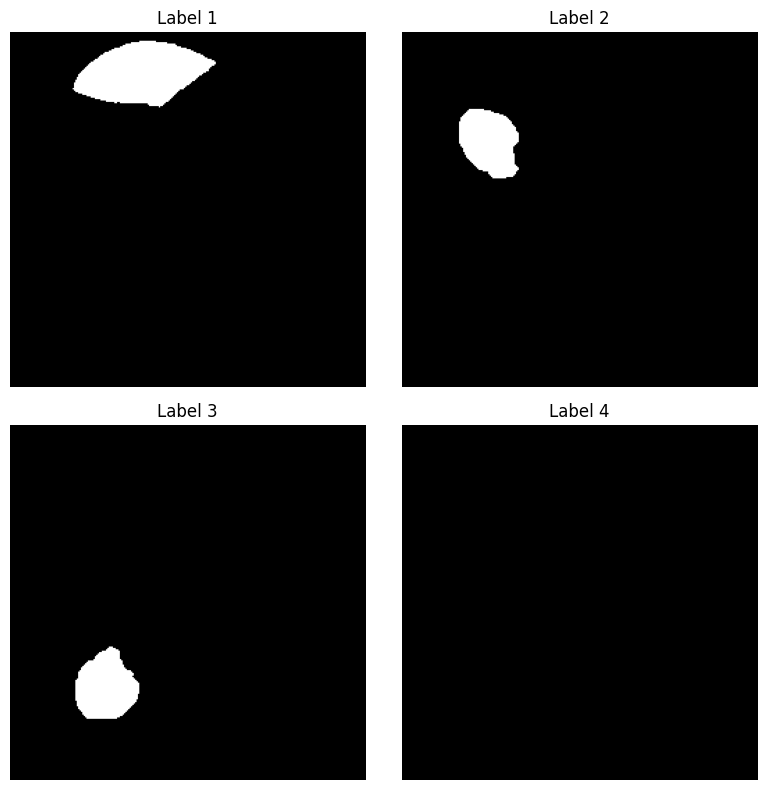

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Đường dẫn tới file .nii.gz của bạn
nii_path = '/root/ducnt/fewshot_medical_segmentor/data/SABS/sabs_CT_normalized/label_1.nii.gz'

# Đọc dữ liệu NIfTI
img = nib.load(nii_path)
data = img.get_fdata()  # Đọc thành numpy array (dạng float)

# Chuyển sang kiểu int nếu là label segmentation
data = data.astype(np.uint8)

# Chọn 1 lát cắt (ví dụ ở giữa volume)
slice_index = 10
slice_data = data[:, :, slice_index]

# Tạo các mặt nạ cho từng label
labels = [1, 2, 3, 6]
masks = [(slice_data == label).astype(np.uint8) for label in labels]

# Hiển thị 4 label theo layout 2x2
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, mask, label in zip(axes.flat, masks, labels):
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'Label {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()


Random Seed:  999
Using device: cuda:0
Device name: GRID A100D-80C


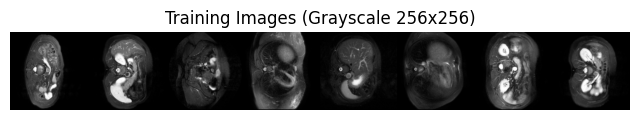

Generator Architecture:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), 

Exception ignored in: <function _releaseLock at 0x7fc4fab24a60>
Traceback (most recent call last):
  File "/root/miniconda3/envs/fss/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


[23/150][0/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[23/150][50/63]	Loss_D: 0.0000	Loss_G: 98.3582	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/150][0/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/150][50/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[25/150][0/63]	Loss_D: 0.0000	Loss_G: 97.9709	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[25/150][50/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[26/150][0/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[26/150][50/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[27/150][0/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[27/150][50/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[28/150][0/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[28/150][50/63]	Loss_D: 0.0000	Loss_G: 100.0000	D(x): 1.0000	D

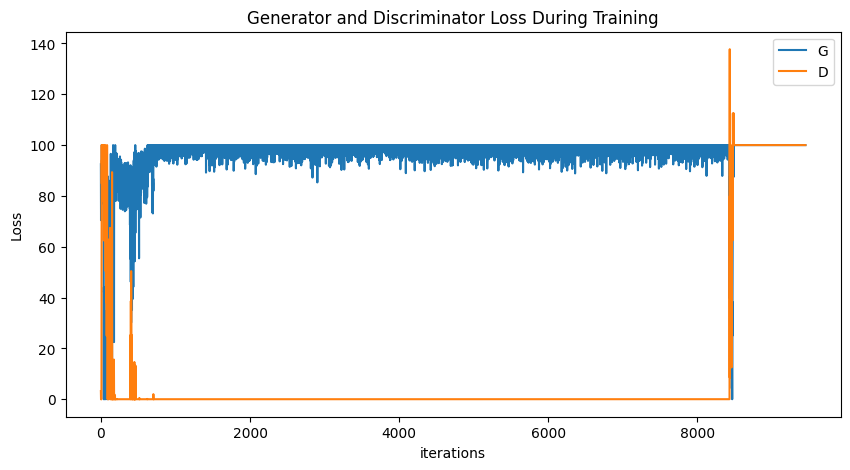

Generating animation...
Animation saved to dcgan_grayscale_256x256_progress.gif

Saving final generated fake images as individual files...
Successfully saved 16 fake images to 'final_fake_images_grayscale_256x256' directory.

Displaying comparison grid...


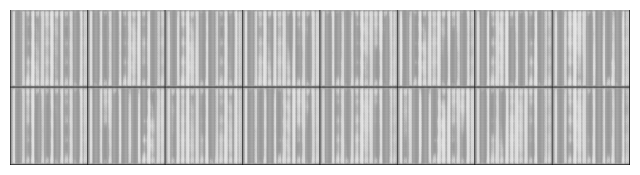

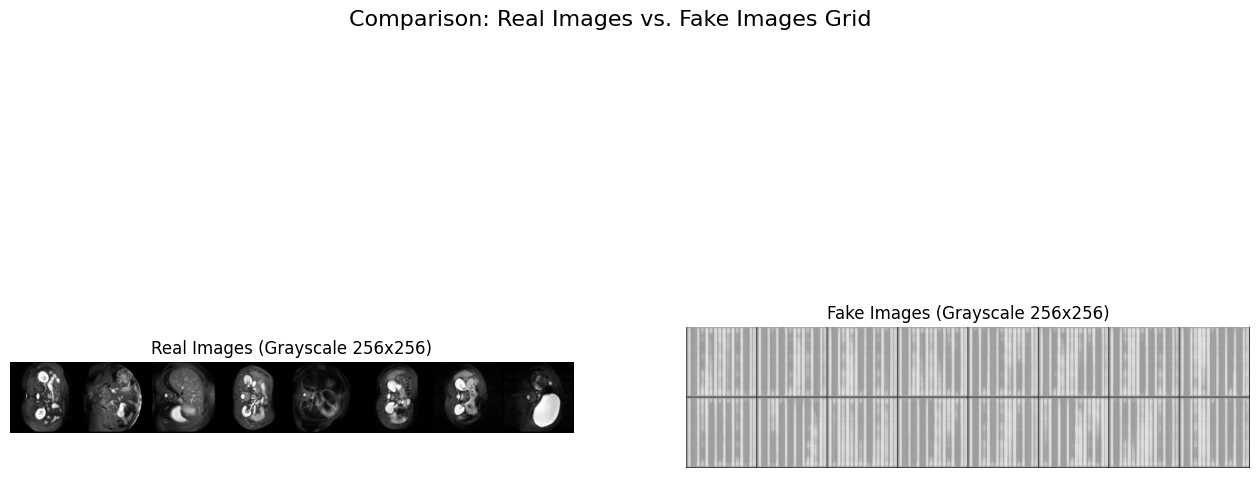


Finished.


In [5]:
# -*- coding: utf-8 -*-
"""
DCGAN Tutorial (Adjusted for 256x256 Grayscale)
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__
"""

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Bỏ comment nếu cần độ tái lập tuyệt đối (có thể chậm hơn)

######################################################################
# Inputs
######################################################################

# Root directory for dataset
dataroot = "/root/ducnt/fewshot_medical_segmentor/stylegan2/data" # Đảm bảo đường dẫn này đúng

# Number of workers for dataloader
workers = 2

# Batch size during training
# <<< QUAN TRỌNG: Giảm batch_size cho ảnh 256x256 >>>
batch_size = 8 # Thử với 8, nếu vẫn lỗi OOM thì giảm xuống 4

# Spatial size of training images. All images will be resized to this size.
# <<< THAY ĐỔI KÍCH THƯỚC ẢNH >>>
image_size = 256

# Number of channels in the training images. 1 for grayscale.
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 150 # Điều chỉnh nếu cần

# Learning rate for optimizers
# <<< Đặt lại LR chuẩn cho DCGAN >>>
lr = 0.001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


######################################################################
# Data
######################################################################

# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size), # Sử dụng image_size=256
                               transforms.CenterCrop(image_size), # Sử dụng image_size=256
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                            #    transforms.Normalize((0.5,), (0.5,)), # <<< Bỏ comment để chuẩn hóa về [-1, 1] >>>
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True) # drop_last=True để tránh batch cuối nhỏ có thể gây lỗi BN

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")


# Plot some training images
try:
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"Training Images (Grayscale {image_size}x{image_size})")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:min(batch_size, 64)], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')
    plt.show()
except StopIteration:
    print("Dataloader is empty. Check dataroot and dataset structure.")
except FileNotFoundError:
    print(f"Error: dataroot '{dataroot}' not found. Please check the path.")
except Exception as e:
    print(f"An error occurred during data loading or plotting: {e}")


######################################################################
# Implementation
######################################################################

# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


######################################################################
# Generator (Kiến trúc điều chỉnh cho 256x256)
######################################################################
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Output size = (InputSize - 1) * Stride - 2 * Padding + KernelSize + OutputPadding
            # Start from 4x4. Need 6 ConvTranspose layers with stride 2 to reach 256x256 (4->8->16->32->64->128->256)
            nn.ConvTranspose2d( nz, ngf * 32, 4, 1, 0, bias=False), # Output: (ngf*32) x 4 x 4
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False), # Output: (ngf*16) x 8 x 8
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False), # Output: (ngf*8) x 16 x 16
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False), # Output: (ngf*4) x 32 x 32
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False), # Output: (ngf*2) x 64 x 64
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),     # Output: (ngf) x 128 x 128
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),      # <<< Output: (nc) x 256 x 256 >>>
            nn.Tanh()
            # final state size. (nc) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print("Generator Architecture:")
print(netG)


######################################################################
# Discriminator (Kiến trúc điều chỉnh cho 256x256)
######################################################################
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: (nc) x 256 x 256
            # Need 6 Conv layers with stride 2 to reach 4x4 (256->128->64->32->16->8->4)
            # Output size = floor((InputSize + 2*Padding - KernelSize) / Stride) + 1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), # Output: (ndf) x 128 x 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # Output: (ndf*2) x 64 x 64
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), # Output: (ndf*4) x 32 x 32
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), # Output: (ndf*8) x 16 x 16
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False), # Output: (ndf*16) x 8 x 8
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False), # <<< Output: (ndf*32) x 4 x 4 >>>
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # Final layer: Conv maps (ndf*32) x 4 x 4 to 1 x 1 x 1
            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False), # Output: 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print("\nDiscriminator Architecture:")
print(netD)


######################################################################
# Loss Functions and Optimizers
######################################################################
criterion = nn.BCELoss()
# Giảm số lượng ảnh trong fixed_noise nếu cần tiết kiệm bộ nhớ GPU khi visualize
fixed_noise_batch_size = min(batch_size * 2, 16) # Ví dụ: Lấy 16 hoặc 32 ảnh để visualize
fixed_noise = torch.randn(fixed_noise_batch_size, nz, 1, 1, device=device)
print(f"Using fixed_noise batch size: {fixed_noise_batch_size}")

real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


######################################################################
# Training
######################################################################
img_list = []
G_losses = []
D_losses = []
iters = 0

print("\nStarting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        try: # Thêm try-except để bắt lỗi tiềm ẩn trong vòng lặp
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            # Nếu dùng drop_last=False, cần kiểm tra size batch cuối
            # b_size = real_cpu.size(0)
            b_size = batch_size # Vì dùng drop_last=True, b_size luôn cố định
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output_real = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output_real, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output_real.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output_fake = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output_fake, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output_fake.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output_fake_for_G = netD(fake).view(-1) # Dùng lại `fake`, không detach()
            # Calculate G's loss based on this output
            errG = criterion(output_fake_for_G, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output_fake_for_G.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0: # In thường xuyên hơn nếu cần
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            # Giảm tần suất lưu ảnh nếu quá trình huấn luyện chậm
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    netG.eval() # Chuyển sang eval mode để tạo ảnh visualize
                    fake_vis = netG(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake_vis, padding=2, normalize=True))
                    netG.train() # Quay lại train mode

            iters += 1

        except Exception as e:
            print(f"\nError during training iteration {iters} (Epoch {epoch}, Batch {i}): {e}")
            # Có thể thêm `break` hoặc `continue` tùy thuộc muốn dừng hẳn hay bỏ qua batch lỗi
            print("Skipping this iteration.")
            # Cần đảm bảo model được đặt lại trạng thái train nếu có lỗi sau khi chuyển sang eval
            if not netG.training: netG.train()
            if not netD.training: netD.train() # Mặc dù D không chuyển eval nhưng để chắc chắn
            continue # Bỏ qua lần lặp này


######################################################################
# Results
######################################################################

# Loss versus training iteration
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualization of G’s progression
if img_list: # Chỉ tạo animation nếu có ảnh được lưu
    print("Generating animation...")
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    # Thêm cmap='gray' cho imshow
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), cmap='gray', animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True) # interval nhanh hơn
    # Hiển thị trong môi trường hỗ trợ (Jupyter/Colab)
    # try:
    #     display(HTML(ani.to_jshtml())) # Sử dụng display() để chắc chắn hiển thị trong notebook
    # except NameError: # Nếu không chạy trong IPython/Jupyter
    #     print("Cannot display animation inline. Saving to file...")
    # Hoặc lưu lại file
    try:
        ani_filename = f"dcgan_grayscale_{image_size}x{image_size}_progress.gif"
        ani.save(ani_filename, writer='pillow', fps=10) # fps cao hơn
        print(f"Animation saved to {ani_filename}")
    except Exception as e:
        print(f"Could not save animation: {e}. Is pillow or imagemagick installed?")
else:
    print("img_list is empty. No animation generated.")


# --- Lưu và Hiển thị kết quả cuối ---
if img_list: # Chỉ thực hiện nếu quá trình huấn luyện đã tạo ra ảnh
    print("\nSaving final generated fake images as individual files...")
    output_dir = f"final_fake_images_grayscale_{image_size}x{image_size}" # Tên thư mục lưu ảnh
    os.makedirs(output_dir, exist_ok=True)        # Tạo thư mục nếu chưa có

    # Đặt model vào chế độ đánh giá (evaluation mode)
    netG.eval()

    # Tạo lại batch ảnh giả cuối cùng từ fixed_noise (hoặc dùng ảnh cuối trong img_list nếu muốn)
    # Để nhất quán, tạo lại từ fixed_noise
    with torch.no_grad():
        final_fake_batch = netG(fixed_noise).detach().cpu()

    # Lưu từng ảnh trong batch
    num_images_saved = 0
    for i in range(final_fake_batch.size(0)): # Lặp qua các ảnh trong fixed_noise batch
        single_fake_image = final_fake_batch[i]
        filename = os.path.join(output_dir, f"fake_image_{i:03d}.png")
        try:
            vutils.save_image(single_fake_image, filename, normalize=True)
            num_images_saved += 1
        except Exception as e:
            print(f"Error saving image {filename}: {e}")

    print(f"Successfully saved {num_images_saved} fake images to '{output_dir}' directory.")
    netG.train() # Đặt lại model về chế độ huấn luyện

    # --- Hiển thị so sánh ảnh thật và ảnh giả (grid) ---
    print("\nDisplaying comparison grid...")
    try:
        # Grab a batch of real images from the dataloader
        real_batch = next(iter(dataloader))

        plt.figure(figsize=(16, 8)) # Điều chỉnh kích thước cho phù hợp

        # Plot Real Images
        plt.subplot(1, 2, 1)
        plt.axis("off")
        plt.title(f"Real Images (Grayscale {image_size}x{image_size})")
        plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:fixed_noise_batch_size], padding=5, normalize=True).cpu(), (1, 2, 0)), cmap='gray')

        # Plot Fake Images (Grid từ fixed_noise batch đã tạo)
        plt.subplot(1, 2, 2)
        plt.axis("off")
        plt.title(f"Fake Images (Grayscale {image_size}x{image_size})")
        plt.imshow(np.transpose(vutils.make_grid(final_fake_batch, padding=2, normalize=True),(1,2,0)), cmap='gray') # Dùng final_fake_batch
        plt.suptitle("Comparison: Real Images vs. Fake Images Grid", fontsize=16)
        plt.show()

    except StopIteration:
        print("Could not grab a real batch to compare (dataloader might be exhausted).")
    except Exception as e:
        print(f"An error occurred during final image plotting: {e}")

else:
    print("No fake images were generated/saved during training (img_list is empty).")


print("\nFinished.")

Saving final generated fake images as individual files...
Successfully saved 16 fake images to 'final_fake_images_grayscale_254' directory.
Displaying comparison grid...


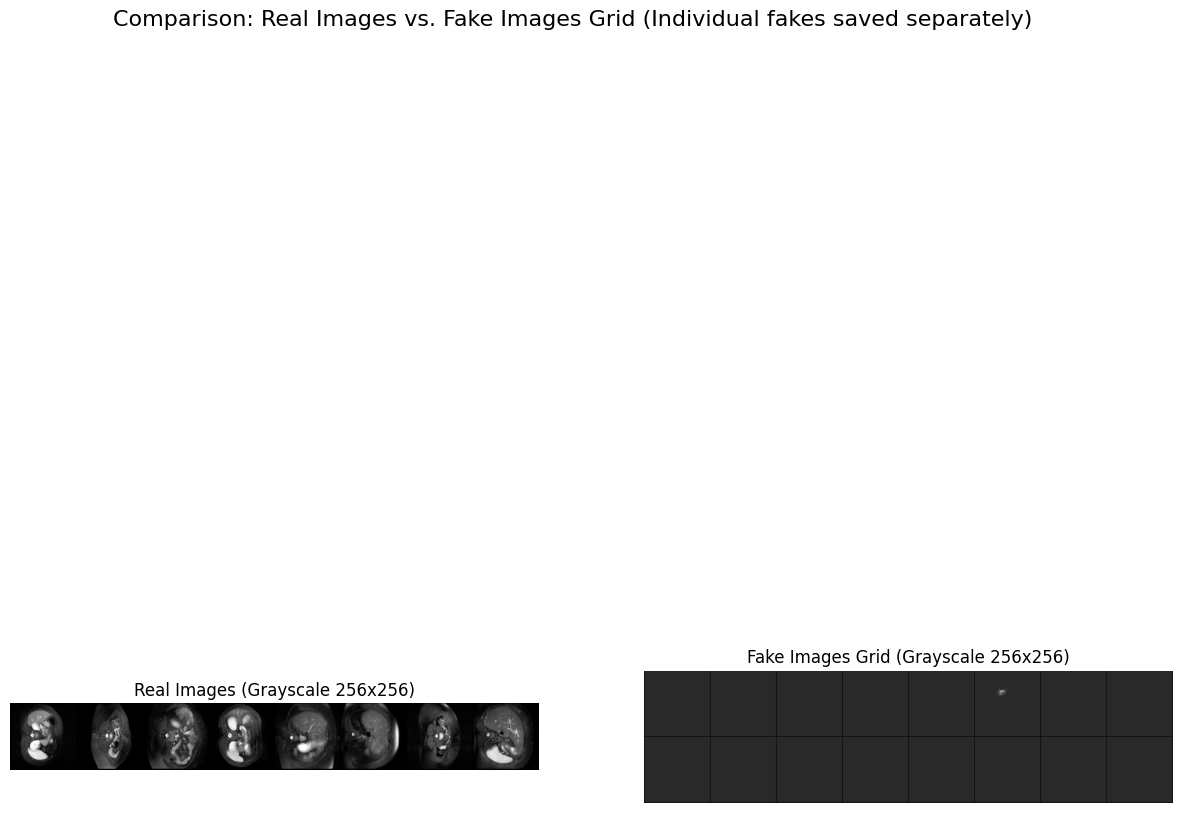

Finished.


In [2]:
import os # Cần import os để tạo thư mục và đường dẫn
import torchvision.utils as vutils # Đảm bảo vutils được import

# ... (Code huấn luyện và các phần hiển thị loss, animation ở trên) ...

######################################################################
# Save and Plot Final Results
######################################################################

# --- Lưu các ảnh giả cuối cùng dưới dạng file riêng lẻ ---
if img_list: # Chỉ thực hiện nếu quá trình huấn luyện đã tạo ra ảnh
    print("Saving final generated fake images as individual files...")
    output_dir = "final_fake_images_grayscale_254" # Tên thư mục lưu ảnh
    os.makedirs(output_dir, exist_ok=True)        # Tạo thư mục nếu chưa có

    # Đặt model vào chế độ đánh giá (evaluation mode) - không bắt buộc nhưng là thực hành tốt
    netG.eval()

    # Tạo lại batch ảnh giả cuối cùng từ fixed_noise
    with torch.no_grad():
        # final_fake_batch có kích thước [batch_size_fixed_noise, nc, image_size, image_size]
        # ví dụ: [64, 1, 256, 256]
        final_fake_batch = netG(fixed_noise).detach().cpu()

    # Lưu từng ảnh trong batch
    num_images_saved = 0
    for i in range(final_fake_batch.size(0)): # Lặp qua 64 ảnh (hoặc kích thước batch của fixed_noise)
        # Lấy ra tensor ảnh đơn lẻ, kích thước [nc, image_size, image_size]
        single_fake_image = final_fake_batch[i]
        # Tạo tên file, ví dụ: final_fake_images_grayscale_256/fake_000.png
        filename = os.path.join(output_dir, f"fake_image_{i:03d}.png")
        try:
            # Lưu ảnh. normalize=True sẽ tự động chuyển khoảng giá trị [-1, 1] (từ Tanh) về [0, 1]
            vutils.save_image(single_fake_image, filename, normalize=True)
            num_images_saved += 1
        except Exception as e:
            print(f"Error saving image {filename}: {e}")

    print(f"Successfully saved {num_images_saved} fake images to '{output_dir}' directory.")

    # Đặt lại model về chế độ huấn luyện nếu cần tiếp tục dùng
    netG.train()

    # --- Hiển thị so sánh ảnh thật và ảnh giả (grid) ---
    print("Displaying comparison grid...")
    try:
        # Grab a batch of real images from the dataloader
        real_batch = next(iter(dataloader))

        plt.figure(figsize=(15, 15)) # Có thể điều chỉnh kích thước nếu muốn

        # Plot Real Images
        plt.subplot(1, 2, 1)
        plt.axis("off")
        plt.title(f"Real Images (Grayscale {image_size}x{image_size})")
        # Hiển thị ảnh thật dưới dạng grid
        plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=5, normalize=True).cpu(), (1, 2, 0)), cmap='gray')

        # Plot Fake Images (Grid từ img_list)
        plt.subplot(1, 2, 2)
        plt.axis("off")
        plt.title(f"Fake Images Grid (Grayscale {image_size}x{image_size})")
        # Hiển thị grid ảnh giả cuối cùng đã lưu trong img_list
        plt.imshow(np.transpose(img_list[-1], (1, 2, 0)), cmap='gray')
        plt.suptitle("Comparison: Real Images vs. Fake Images Grid (Individual fakes saved separately)", fontsize=16)
        plt.show()

    except StopIteration:
        print("Could not grab a real batch to compare (dataloader might be exhausted).")
    except Exception as e:
        print(f"An error occurred during final image plotting: {e}")

else:
    print("No fake images were generated/saved during training (img_list is empty).")

print("Finished.")

In [25]:
sample_image_tensor, sample_label = dataset[0] # Lấy ảnh đầu tiên

print("Kích thước Tensor ảnh mẫu:", sample_image_tensor.shape)
print("Kiểu dữ liệu Tensor:", sample_image_tensor.dtype)
print("Giá trị nhỏ nhất:", sample_image_tensor.min())
print("Giá trị lớn nhất:", sample_image_tensor.max())
print("Nhãn (thư mục chứa ảnh):", sample_label, "Tên lớp:", dataset.classes[sample_label])


Kích thước Tensor ảnh mẫu: torch.Size([1, 256, 256])
Kiểu dữ liệu Tensor: torch.float32
Giá trị nhỏ nhất: tensor(0.)
Giá trị lớn nhất: tensor(1.)
Nhãn (thư mục chứa ảnh): 0 Tên lớp: images


Kích thước ảnh để hiển thị: torch.Size([256, 256])


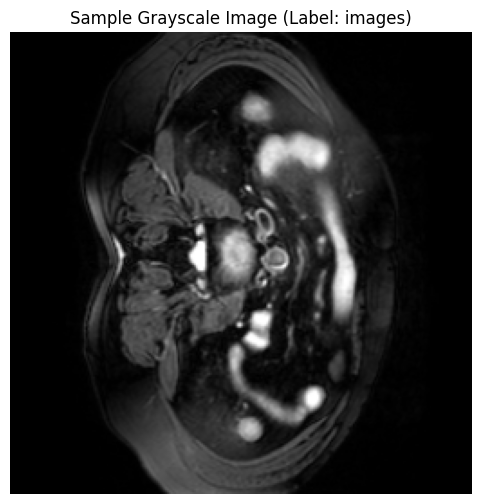

In [26]:


sample_image_display = sample_image_tensor.squeeze()
# Hoặc dùng permute: sample_image_display = sample_image_tensor.permute(1, 2, 0)

# Kiểm tra kích thước sau khi squeeze
print("Kích thước ảnh để hiển thị:", sample_image_display.shape)

# Hiển thị ảnh
plt.figure(figsize=(6, 6))
plt.imshow(sample_image_display.numpy(), cmap='gray') # Chuyển về numpy và dùng cmap='gray'
plt.title(f"Sample Grayscale Image (Label: {dataset.classes[sample_label]})")
plt.axis('off') # Tắt trục tọa độ
plt.show()
